# I. MLP with Auto MPG data

# 1. Import libraries

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 2. Initialize gpu settings

In [12]:
# Set random seed
random_state = 59
np.random.seed(random_state) # for numpy
torch.manual_seed(random_state) # for cpu
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_state)  # for gpu

In [13]:
# Activate gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 3. Read dataset

In [14]:
dataset_path = "/content/dataset/Auto_MPG_data.csv"
dataset = pd.read_csv(dataset_path)

In [15]:
dataset.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
0,18.0,8,307.0,130.0,3504.0,12.0,70,0,0,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,0,0,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,0,0,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,0,0,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,0,0,1


# 4. Preprocess the data

## 4.1 Split train, test from the data

In [16]:
# Get features and their label
X = dataset.iloc[:, 1:].values
y = dataset.iloc[:, 0].values

# Set split ratio
val_size = 0.2
test_size = 0.125
is_shuffle = True

# Split train, val set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=val_size, random_state=random_state, shuffle=is_shuffle)
# Split train, test set
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=test_size, random_state=random_state, shuffle=is_shuffle)

In [17]:
print(f"Numbers: train: {len(X_train)} - valid: {len(X_val)} - test: {len(X_test)}")

Numbers: train: 273 - valid: 79 - test: 40


## 4.2 Normalize the data

In [18]:
normalizer = StandardScaler()
X_train = normalizer.fit_transform(X_train)
X_val = normalizer.transform(X_val)
X_test = normalizer.transform(X_test)

X_train = torch.tensor(X_train, dtype = torch.float32)
X_val = torch.tensor(X_val, dtype = torch.float32)
X_test = torch.tensor(X_test, dtype = torch.float32)
y_train = torch.tensor(y_train, dtype = torch.float32)
y_val = torch.tensor(y_val, dtype = torch.float32)
y_test = torch.tensor(y_test, dtype = torch.float32)

In [19]:
print(f"Train: {X_train[:5]}")

Train: tensor([[-0.8414, -1.0379, -1.0381, -1.0061,  0.7828,  1.1191, -0.4443,  1.9045,
         -1.2748],
        [ 0.3676,  0.3682,  0.2230,  0.8179,  1.0772,  0.5731, -0.4443, -0.5251,
          0.7845],
        [-0.8414, -0.9165, -0.8980, -0.9940, -0.1001,  1.1191, -0.4443, -0.5251,
          0.7845],
        [-0.8414, -0.9266, -0.9821, -0.9638,  0.8196,  1.1191, -0.4443,  1.9045,
         -1.2748],
        [-0.8414, -0.7547, -0.3095, -0.4359, -0.6520, -0.7921,  2.2509, -0.5251,
         -1.2748]])


# 5. Initialize Pytorch settings

## 5.1 Create DataLoader

In [20]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

## 5.2 Create MLP network

In [21]:
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super().__init__()
        self.linear1 = nn.Linear(input_dims, hidden_dims)
        self.linear2 = nn.Linear(hidden_dims, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)

    def forward(self, x):
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        output = self.output(x)
        return output.squeeze(1)

## 5.3 Activate moudules

In [22]:
# For DataLoader
batch_size = 32
train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# For MLP
input_dims = X_train.shape[1]
hidden_dims = 64
output_dims = 1

model = MLP(input_dims=input_dims, hidden_dims=hidden_dims, output_dims=output_dims).to(device)

# For optimizers
lr = 1e-2
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [23]:
def r_squared(y_true, y_pred):
    y_true = torch.Tensor(y_true)
    y_pred = torch.Tensor(y_pred)
    mean_true = torch.mean(y_true)
    ss_tot = torch.sum((y_true - mean_true) ** 2)
    ss_res = torch.sum((y_true - y_pred ) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    return r2

# 6. Train the model

In [24]:
epochs = 100
train_losses = []
val_losses = []
train_r2 = []
val_r2 = []

for epoch in range(epochs):
    train_loss = 0.0
    train_target = []
    train_predict = []

    model.train()
    for X_samples, y_samples in train_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        optimizer.zero_grad()
        outputs = model(X_samples)

        train_predict.append(outputs.detach().cpu())
        train_target.append(y_samples.cpu())
        loss = criterion(outputs, y_samples)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    train_predict = torch.cat(train_predict)
    train_target = torch.cat(train_target)
    train_r2.append(r_squared(train_target, train_predict))

    model.eval()
    val_loss = 0.0
    val_target = []
    val_predict = []
    with torch.no_grad():
        for X_samples, y_samples in val_loader:
            X_samples = X_samples.to(device)
            y_samples = y_samples.to(device)
            outputs = model(X_samples)
            val_predict.append(outputs.cpu())
            val_target.append(y_samples.cpu())
            loss = criterion(outputs, y_samples)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_predict = torch.cat(val_predict)
    val_target = torch.cat(val_target)
    val_r2.append(r_squared(val_target, val_predict))
    print(f"\nEPOCH {epoch + 1}:\tTraining loss: {train_loss:.3f}\tValidation loss: {val_loss:.3f}")


EPOCH 1:	Training loss: 282.769	Validation loss: 88.672

EPOCH 2:	Training loss: 137.669	Validation loss: 72.346

EPOCH 3:	Training loss: 71.007	Validation loss: 19.143

EPOCH 4:	Training loss: 25.083	Validation loss: 196.176

EPOCH 5:	Training loss: 96.139	Validation loss: 20.444

EPOCH 6:	Training loss: 17.765	Validation loss: 9.444

EPOCH 7:	Training loss: 18.486	Validation loss: 14.535

EPOCH 8:	Training loss: 37.859	Validation loss: 37.427

EPOCH 9:	Training loss: 17.133	Validation loss: 38.134

EPOCH 10:	Training loss: 22.991	Validation loss: 41.183

EPOCH 11:	Training loss: 26.723	Validation loss: 20.063

EPOCH 12:	Training loss: 9.852	Validation loss: 5.594

EPOCH 13:	Training loss: 15.143	Validation loss: 16.025

EPOCH 14:	Training loss: 12.213	Validation loss: 12.023

EPOCH 15:	Training loss: 14.222	Validation loss: 7.731

EPOCH 16:	Training loss: 10.845	Validation loss: 18.904

EPOCH 17:	Training loss: 12.312	Validation loss: 14.885

EPOCH 18:	Training loss: 15.474	Validati

# 7. Visualize the model

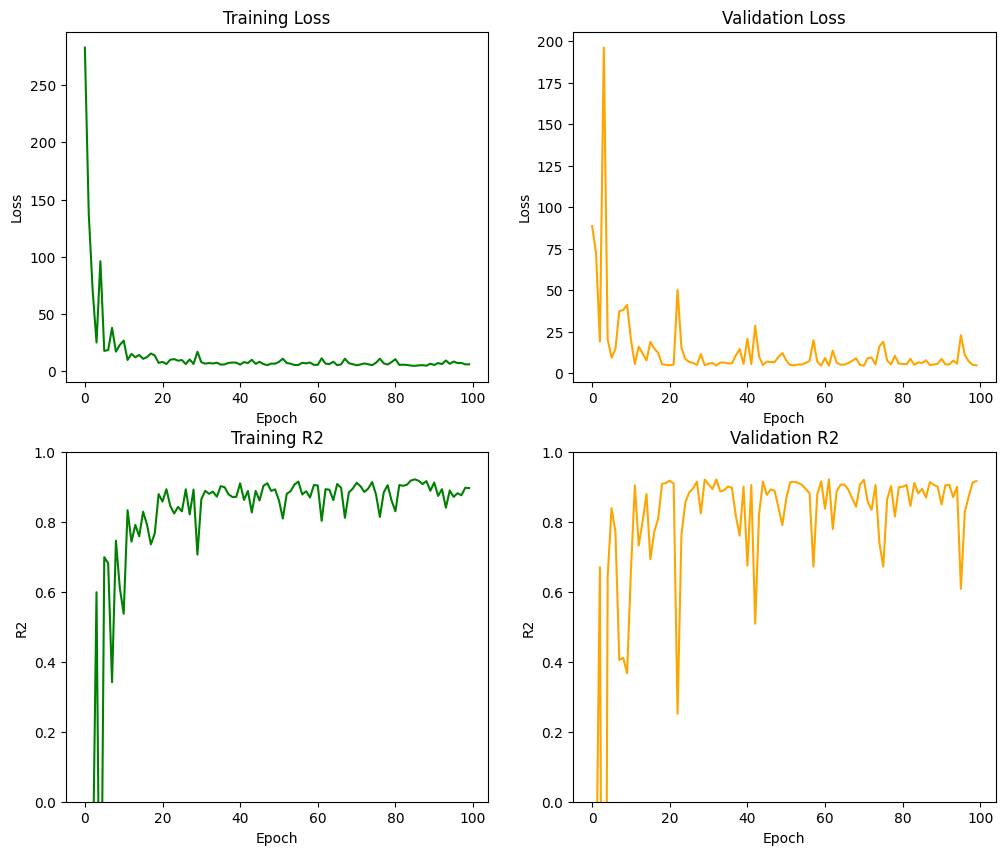

In [25]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_losses, color="green")
ax[0, 0].set(xlabel="Epoch", ylabel="Loss")
ax[0, 0].set_title("Training Loss")

ax[0, 1].plot(val_losses, color="orange")
ax[0, 1].set(xlabel ="Epoch", ylabel="Loss")
ax[0, 1].set_title ("Validation Loss")

ax[1, 0].plot(train_r2, color="green")
ax[1, 0].set(xlabel="Epoch", ylabel="R2")
ax[1, 0].set_ylim([0, 1])
ax[1, 0].set_title("Training R2")

ax[1, 1].plot(val_r2, color="orange")
ax[1, 1].set(xlabel="Epoch", ylabel="R2")
ax[1, 1].set_ylim([0, 1])
ax[1, 1].set_title ("Validation R2")

plt.show()

# 8. Evaluate the model

In [26]:
model.eval()
with torch.no_grad():
    y_hat = model(X_test.to(device))
    test_set_r2 = r_squared(y_hat.cpu(), y_test.cpu())
    print("Evaluation on test set: ")
    print(f"R2: {test_set_r2}")

Evaluation on test set: 
R2: 0.8417800068855286


# II. MLP with non-linear data

# 1. Import libraries

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 2. Initialize gpu settings

In [28]:
# Set random seed
random_state = 59
np.random.seed(random_state)
torch.manual_seed(random_state)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_state)

# Activate gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 3. Read dataset

In [29]:
data_path = "/content/dataset/NonLinear_data.npy"
data = np.load(data_path, allow_pickle=True).item()
X, y = data["X"], data["labels"]
print(f"X_shape: {X.shape} - y_shape: {y.shape}")

X_shape: (300, 2) - y_shape: (300,)


# 4. Preprocess the data

## 4.1 Split train, test from the data

In [30]:
# Set split ratio
val_size = 0.2
test_size = 0.125
is_shuffle = True

# Split train, val set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=val_size, random_state=random_state, shuffle=is_shuffle)
# Split train, test set
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=test_size, random_state=random_state, shuffle=is_shuffle)

## 4.2 Normalize the data

In [31]:
normalizer = StandardScaler()
X_train = normalizer.fit_transform(X_train)
X_val = normalizer.transform(X_val)
X_test = normalizer.transform(X_test)

X_train = torch.tensor(X_train, dtype = torch.float32)
X_val = torch.tensor(X_val, dtype = torch.float32)
X_test = torch.tensor(X_test, dtype = torch.float32)
y_train = torch.tensor(y_train, dtype = torch.long)
y_val = torch.tensor(y_val, dtype = torch.long)
y_test = torch.tensor(y_test, dtype = torch.long)

# 5. Initialize Pytorch settings

## 5.1 Create DataLoader

In [32]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

## 5.2 Create MLP network

In [33]:
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(input_dims, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)

    def forward(self, x):
        x = self.linear1(x)
        x = F.relu(x)
        output = self.output(x)
        return output.squeeze(1)

## 5.3 Activate moudules

In [35]:
# For DataLoader
batch_size = 32
train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)
test_dataset = CustomDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# For MLP
input_dims = X_train.shape[1]
hidden_dims = 128
output_dims = torch.unique(y_train).shape[0]

model = MLP(input_dims=input_dims, hidden_dims=hidden_dims, output_dims=output_dims).to(device)

# For optimizers
lr = 1e-1
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [36]:
def compute_accuracy(y_hat, y_true):
    _, y_hat = torch.max(y_hat, dim=1)
    correct = (y_hat == y_true).sum().item()
    accuracy = correct / len(y_true)
    return accuracy

# 6. Train the model

In [37]:
epochs = 100
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(epochs):
    train_loss = 0.0
    train_target = []
    train_predict = []

    model.train()
    for X_samples, y_samples in train_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        optimizer.zero_grad()
        outputs = model(X_samples)
        loss = criterion(outputs, y_samples)
        loss.backward()
        optimizer.step()

        train_predict.append(outputs.detach().cpu())
        train_target.append(y_samples.cpu())
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    train_predict = torch.cat(train_predict)
    train_target = torch.cat(train_target)
    train_acc = compute_accuracy(train_predict, train_target)
    train_accs.append(train_acc)

    model.eval()
    val_loss = 0.0
    val_target = []
    val_predict = []
    with torch.no_grad():
        for X_samples, y_samples in val_loader:
            X_samples = X_samples.to(device)
            y_samples = y_samples.to(device)
            outputs = model(X_samples)
            loss = criterion(outputs, y_samples)
            val_loss += loss.item()

            val_predict.append(outputs.cpu())
            val_target.append(y_samples.cpu())
    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    val_predict = torch.cat(val_predict)
    val_target = torch.cat(val_target)
    val_acc = compute_accuracy(val_predict, val_target)
    val_accs.append(val_acc)
    print(f"\nEPOCH {epoch + 1}:\tTraining loss: {train_loss:.3f}\tValidation loss: {val_loss:.3f}")


EPOCH 1:	Training loss: 0.900	Validation loss: 0.854

EPOCH 2:	Training loss: 0.746	Validation loss: 0.830

EPOCH 3:	Training loss: 0.704	Validation loss: 0.798

EPOCH 4:	Training loss: 0.690	Validation loss: 0.778

EPOCH 5:	Training loss: 0.666	Validation loss: 0.778

EPOCH 6:	Training loss: 0.653	Validation loss: 0.757

EPOCH 7:	Training loss: 0.650	Validation loss: 0.722

EPOCH 8:	Training loss: 0.633	Validation loss: 0.720

EPOCH 9:	Training loss: 0.620	Validation loss: 0.693

EPOCH 10:	Training loss: 0.588	Validation loss: 0.685

EPOCH 11:	Training loss: 0.581	Validation loss: 0.659

EPOCH 12:	Training loss: 0.552	Validation loss: 0.643

EPOCH 13:	Training loss: 0.562	Validation loss: 0.628

EPOCH 14:	Training loss: 0.549	Validation loss: 0.621

EPOCH 15:	Training loss: 0.542	Validation loss: 0.594

EPOCH 16:	Training loss: 0.527	Validation loss: 0.582

EPOCH 17:	Training loss: 0.512	Validation loss: 0.568

EPOCH 18:	Training loss: 0.504	Validation loss: 0.559

EPOCH 19:	Training

# 7. Visualize the model

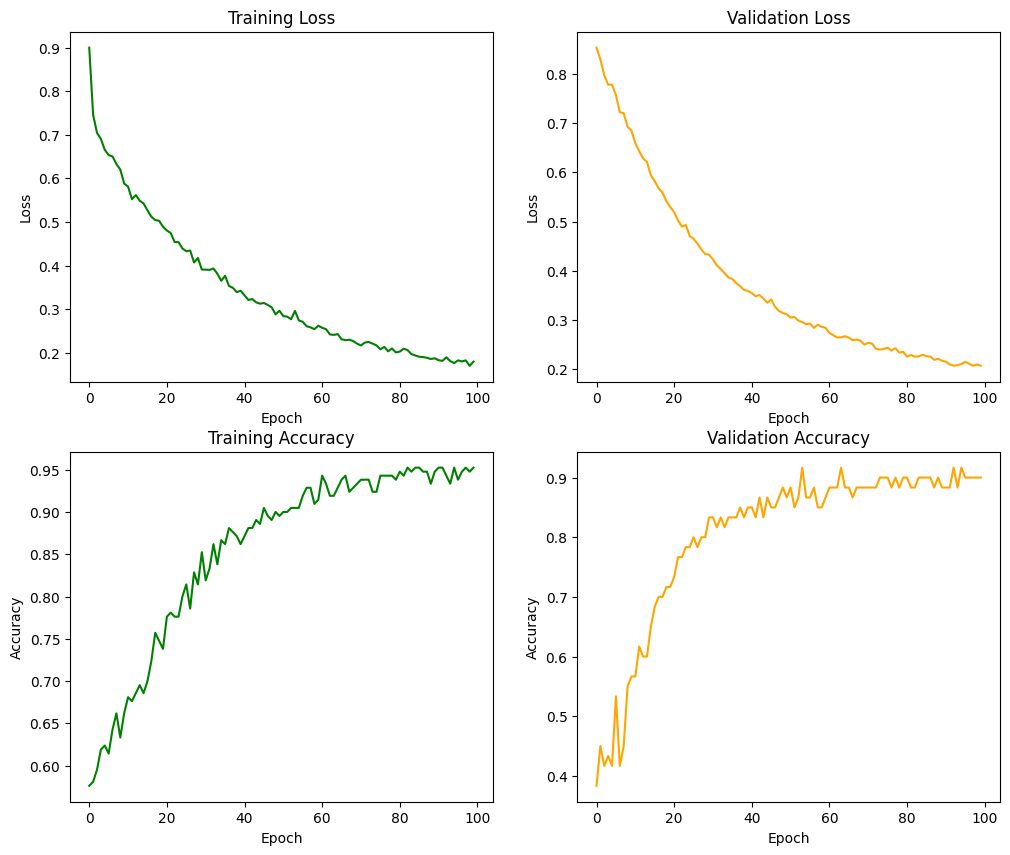

In [38]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_losses, color="green")
ax[0, 0].set(xlabel="Epoch", ylabel="Loss")
ax[0, 0].set_title("Training Loss")

ax[0, 1].plot(val_losses, color="orange")
ax[0, 1].set(xlabel ="Epoch", ylabel="Loss")
ax[0, 1].set_title ("Validation Loss")

ax[1, 0].plot(train_accs, color="green")
ax[1, 0].set(xlabel="Epoch", ylabel="Accuracy")
ax[1, 0].set_title("Training Accuracy")

ax[1, 1].plot(val_accs, color="orange")
ax[1, 1].set(xlabel="Epoch", ylabel="Accuracy")
ax[1, 1].set_title ("Validation Accuracy")

plt.show()

# 8. Evaluate the model

In [39]:
test_target = []
test_predict = []
model.eval()
with torch.no_grad():
    for X_samples, y_samples in test_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        outputs = model(X_samples)

        test_predict.append(outputs.cpu())
        test_target.append(y_samples.cpu())

test_predict = torch.cat(test_predict)
test_target = torch.cat(test_target)
test_acc = compute_accuracy(test_predict, test_target)

print("Evaluation on test set: ")
print(f"Accuracy: {test_acc}")

Evaluation on test set: 
Accuracy: 0.9


# III. Emotional Image Classification

# 1. Import libraries

In [1]:
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Resize
from torchvision.io import read_image

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 2. Initialize gpu settings

In [2]:
# Set random seed
random_state = 59
np.random.seed(random_state)
torch.manual_seed(random_state)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_state)

# Activate gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 3. Read dataset

In [14]:
!unzip "/content/dataset/FER-2013.zip" -d "/content/dataset/FER-2013"

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/FER-2013/train/sad/Training_65242339.jpg  
  inflating: /content/dataset/FER-2013/train/sad/Training_65267116.jpg  
  inflating: /content/dataset/FER-2013/train/sad/Training_65275626.jpg  
  inflating: /content/dataset/FER-2013/train/sad/Training_6529266.jpg  
  inflating: /content/dataset/FER-2013/train/sad/Training_65329617.jpg  
  inflating: /content/dataset/FER-2013/train/sad/Training_65338712.jpg  
  inflating: /content/dataset/FER-2013/train/sad/Training_65338797.jpg  
  inflating: /content/dataset/FER-2013/train/sad/Training_65387162.jpg  
  inflating: /content/dataset/FER-2013/train/sad/Training_65404494.jpg  
  inflating: /content/dataset/FER-2013/train/sad/Training_65426218.jpg  
  inflating: /content/dataset/FER-2013/train/sad/Training_65430136.jpg  
  inflating: /content/dataset/FER-2013/train/sad/Training_65437377.jpg  
  inflating: /content/dataset/FER-2013/train/sad/Training_6545735.jpg  
  

# 4. Initialize Pytorch *settings*

## 4.1 Create DataLoader

In [3]:
class ImageDataset(Dataset):
    def __init__(self, img_dir, norm, label2idx, split="train", train_ratio=0.8, remain_data=None):
        img_height, img_width = (128, 128)
        self.resize = Resize((img_height, img_width))
        self.norm = norm
        self.split = split
        self.train_ratio = train_ratio
        self.img_dir = img_dir
        self.label2idx = label2idx
        if split in["train", "test"]:
            self.img_paths, self.img_labels = self.read_img_files()
        self.remain_data = remain_data

        if split == "train":
            train_data, val_data = train_test_split(list(zip(self.img_paths, self.img_labels)), train_size=train_ratio, random_state=random_state, stratify=self.img_labels)
            self.img_paths, self.img_labels = zip(*train_data)
            self.remain_data = val_data
        elif split == "val":
            self.img_paths, self.img_labels = zip(*self.remain_data)

    def read_img_files(self):
        img_paths = []
        img_labels = []
        for cls in self.label2idx.keys():
            for img in os.listdir(os.path.join(self.img_dir, cls)):
                img_paths.append(os.path.join(self.img_dir, cls, img))
                img_labels.append(cls)

        return img_paths, img_labels

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        cls = self.img_labels[idx]
        img = self.resize(read_image(img_path))
        img = img.type(torch.float32)
        label = self.label2idx[cls]
        if self.norm:
            img = (img / 127.5) - 1
        return img, label

## 4.2 Create MLP network

In [4]:
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(input_dims, hidden_dims)
        self.linear2 = nn.Linear(hidden_dims, hidden_dims)
        self.linear3 = nn.Linear(hidden_dims, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)

    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        x = self.linear3(x)
        x = F.relu(x)
        output = self.output(x)
        return output.squeeze(1)

## 4.3 Activate moudules

In [5]:
# Init the data paths
train_dir = "/content/dataset/FER-2013/train"
test_dir = "/content/dataset/FER-2013/test"

classes = os.listdir(train_dir)

label2idx = {cls:idx for idx, cls in enumerate(classes)}
idx2label = {idx:cls for cls, idx in label2idx.items()}

# For DataLoader
batch_size = 256
train_dataset = ImageDataset(train_dir, True, label2idx, split="train")
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = ImageDataset(train_dir, True, label2idx, split="val", remain_data=train_dataset.remain_data)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

test_dataset = ImageDataset(test_dir, True, label2idx, split="test")
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# For MLP
img_height, img_width = (128, 128)
input_dims = img_height * img_width
hidden_dims = 64
output_dims = len(classes)

model = MLP(input_dims=input_dims, hidden_dims=hidden_dims, output_dims=output_dims).to(device)

# For optimizers
lr = 1e-2
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

## 4.4 Visualize the data


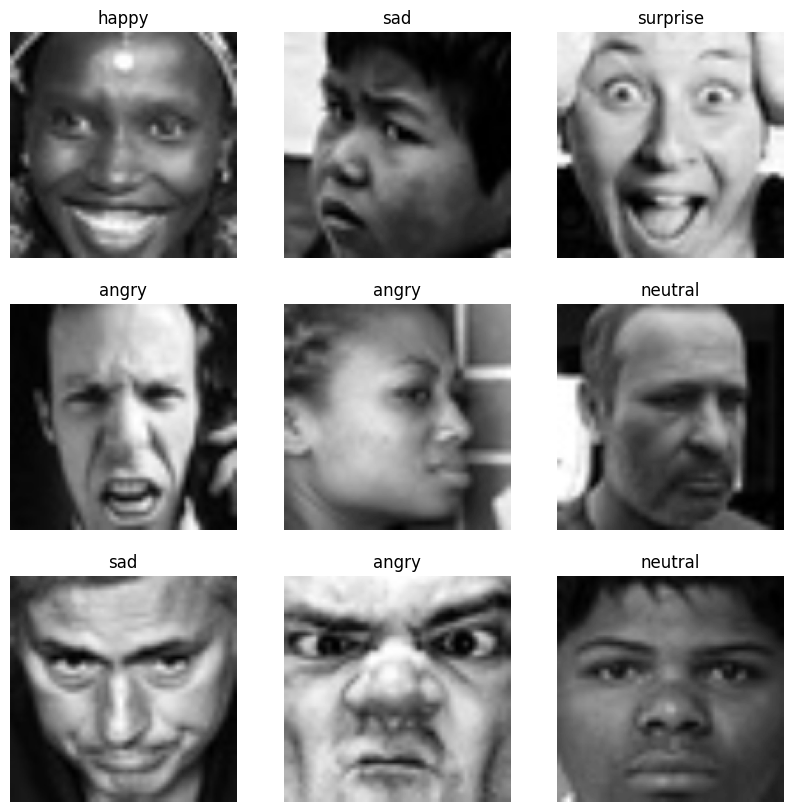

In [ ]:
image_batch, label_batch = next(iter(train_loader))

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    minv = image_batch[i].numpy().min()
    maxv = image_batch[i].numpy().max()
    plt.imshow(np.squeeze(image_batch[i].numpy()), vmin=minv, vmax=maxv, cmap="gray")
    label = label_batch[i]
    plt.title(idx2label[label.item()])
    plt.axis("off")

In [7]:
def compute_accuracy(y_hat, y_true):
    _, y_hat = torch.max(y_hat, dim=1)
    correct = (y_hat == y_true).sum().item()
    accuracy = correct / len(y_true)
    return accuracy

# 5. Train the model

In [8]:
epochs = 40
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(epochs):
    train_loss = 0.0
    train_target = []
    train_predict = []

    model.train()
    for X_samples, y_samples in train_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        optimizer.zero_grad()
        outputs = model(X_samples)
        loss = criterion(outputs, y_samples)
        loss.backward()
        optimizer.step()

        train_predict.append(outputs.detach().cpu())
        train_target.append(y_samples.cpu())
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    train_predict = torch.cat(train_predict)
    train_target = torch.cat(train_target)
    train_acc = compute_accuracy(train_predict, train_target)
    train_accs.append(train_acc)

    model.eval()
    val_loss = 0.0
    val_target = []
    val_predict = []
    with torch.no_grad():
        for X_samples, y_samples in val_loader:
            X_samples = X_samples.to(device)
            y_samples = y_samples.to(device)
            outputs = model(X_samples)
            loss = criterion(outputs, y_samples)
            val_loss += loss.item()

            val_predict.append(outputs.cpu())
            val_target.append(y_samples.cpu())
    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    val_predict = torch.cat(val_predict)
    val_target = torch.cat(val_target)
    val_acc = compute_accuracy(val_predict, val_target)
    val_accs.append(val_acc)
    print(f"\nEPOCH {epoch + 1}:\tTraining loss: {train_loss:.3f}\tValidation loss: {val_loss:.3f}")


EPOCH 1:	Training loss: 1.824	Validation loss: 1.815

EPOCH 2:	Training loss: 1.801	Validation loss: 1.796

EPOCH 3:	Training loss: 1.784	Validation loss: 1.781

EPOCH 4:	Training loss: 1.770	Validation loss: 1.769

EPOCH 5:	Training loss: 1.757	Validation loss: 1.755

EPOCH 6:	Training loss: 1.741	Validation loss: 1.738

EPOCH 7:	Training loss: 1.722	Validation loss: 1.719

EPOCH 8:	Training loss: 1.701	Validation loss: 1.697

EPOCH 9:	Training loss: 1.679	Validation loss: 1.678

EPOCH 10:	Training loss: 1.660	Validation loss: 1.661

EPOCH 11:	Training loss: 1.646	Validation loss: 1.650

EPOCH 12:	Training loss: 1.634	Validation loss: 1.642

EPOCH 13:	Training loss: 1.624	Validation loss: 1.633

EPOCH 14:	Training loss: 1.615	Validation loss: 1.628

EPOCH 15:	Training loss: 1.606	Validation loss: 1.622

EPOCH 16:	Training loss: 1.598	Validation loss: 1.623

EPOCH 17:	Training loss: 1.591	Validation loss: 1.611

EPOCH 18:	Training loss: 1.583	Validation loss: 1.610

EPOCH 19:	Training

# 6. Visualize the model

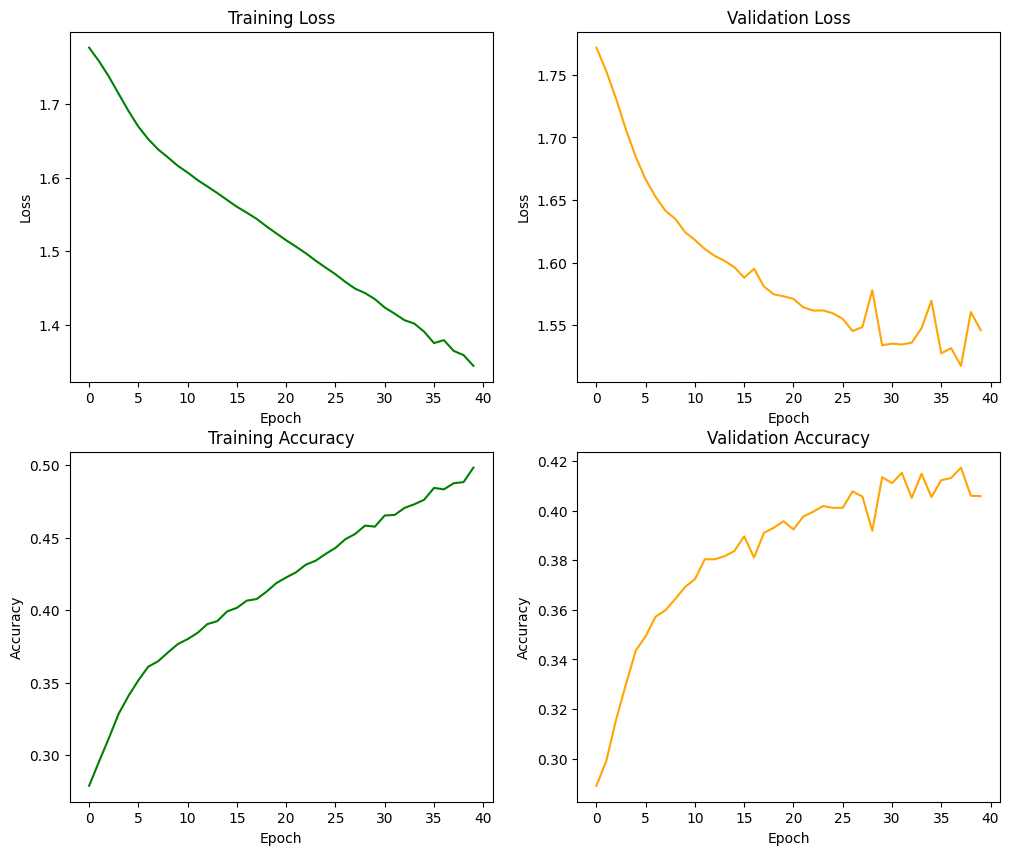

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_losses, color="green")
ax[0, 0].set(xlabel="Epoch", ylabel="Loss")
ax[0, 0].set_title("Training Loss")

ax[0, 1].plot(val_losses, color="orange")
ax[0, 1].set(xlabel ="Epoch", ylabel="Loss")
ax[0, 1].set_title ("Validation Loss")

ax[1, 0].plot(train_accs, color="green")
ax[1, 0].set(xlabel="Epoch", ylabel="Accuracy")
ax[1, 0].set_title("Training Accuracy")

ax[1, 1].plot(val_accs, color="orange")
ax[1, 1].set(xlabel="Epoch", ylabel="Accuracy")
ax[1, 1].set_title ("Validation Accuracy")

plt.show()

# 7. Evaluate the model

In [10]:
test_target = []
test_predict = []
model.eval()
with torch.no_grad():
    for X_samples, y_samples in test_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        outputs = model(X_samples)

        test_predict.append(outputs.cpu())
        test_target.append(y_samples.cpu())

test_predict = torch.cat(test_predict)
test_target = torch.cat(test_target)
test_acc = compute_accuracy(test_predict, test_target)

print("Evaluation on test set: ")
print(f"Accuracy: {test_acc}")

Evaluation on test set: 
Accuracy: 0.3989969350794093


In [ ]:
test_img_path = "/content/dataset/FER-2013/train/angry/Training_10118481.jpg"
img = cv2.imread(test_img_path)

print(f"Image height: {img_height}")
print(f"Image width: {img_width}")